# Machine Learning with TensorFlow

## Tensors

In [1]:
import tensorflow as tf
import tensorflow.compat.v2.feature_column
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib
from random import randrange

### Tensor rank and shape

Tensors can have rank 0-n (basically refers to the dimensions). <br>
Tensors' shape is the amount of elements/data in the tensors. <br>
* Shapes can be reshaped.

In [2]:
#Declare and initialize tensors
rank0_tensor = tf.Variable(9, tf.int16)
rank1_tensor = tf.Variable([1,2,3], tf.float64)
rank2_tensor = tf.Variable([[1,2,3], [4,5,6]], tf.int16)
rank3_tensor = tf.Variable([[[1,2,3],[4,5,6]],[[7,8,9],[10,11,12]]], tf.int16)

In [7]:
#Get rank of tensor
tf.rank(rank1_tensor)

#Get shape of tensor
rank1_tensor.shape
rank2_tensor.shape
rank3_tensor.shape

TensorShape([2, 2, 3])

In [8]:
#Reshape tensors

#Will create tensor with given shape with all 1
#tf.zeros also exits
oneTensor = tf.ones([2,3])
oneTensor = tf.zeros([2,3])
print(oneTensor)

#Reshape
#-1 lets TensorFlow infer the dimension for that value
oneTensor = tf.reshape(oneTensor, [6])
newRank2Tensor = tf.reshape(rank3_tensor, [2,6])
print(newRank2Tensor)
tf.rank(newRank2Tensor)

tf.Tensor(
[[0. 0. 0.]
 [0. 0. 0.]], shape=(2, 3), dtype=float32)
tf.Tensor(
[[ 1  2  3  4  5  6]
 [ 7  8  9 10 11 12]], shape=(2, 6), dtype=int32)


<tf.Tensor: shape=(), dtype=int32, numpy=2>

### Tensor types
All tensor type are immutable except for "Variable". Availabe tensor types are: <br>
* Variable
* Constant
* Placeholder
* SparseTensor

### Evaluating tensors
Create session. <br>
The code evaluates the tensor variable that is stored in the default graph. The default graph holds all operations not specified to another graph. It is possible to create own seperate graphs.

In [9]:
#with tf.Session() as session: #this uses the default graph
    #oneTensor.eval() #tensor to evaluate

## TensorFlow's Core Learning Algorithms

### Linear Regression
Creates a line of best fit through a scatter plot of data
points that best expresses the relationship between those points. <br>
This can be done in any kind of dimensions. <br>

Feature columns are columns that contain the unique data, either categorical or numerical, per column of input data.

Epochs are the times the model re-evaluates data and thus learns from it.

Overfitting occurs when the same data is feed to the model too much, data is almost memorized which degrades future predictions.

Batches are used to feed smaller amounts to the model.

Data from: https://www.kaggle.com/uciml/pima-indians-diabetes-database

In [10]:
#Load data
#Load train data
dfTrain = pd.read_csv('CSV_Data/diabetes_train.csv')
dfTrain.pop('SkinThickness')
dfTrain.pop('Insulin')

#Load evaluation data
dfEvaluate = pd.read_csv('CSV_Data/diabetes_eval.csv')
dfEvaluate.pop('SkinThickness')
dfEvaluate.pop('Insulin')

#Pop the label
y_train = dfTrain.pop('Outcome')
y_evaluate = dfEvaluate.pop('Outcome')

#Just list
#y_train.head()
dfTrain.head()

#Statistical
dfTrain.describe()

#dfTrain.shape

,Pregnancies,Glucose,BloodPressure,BMI,DiabetesPedigreeFunction,Age
count,591.000000,591.000000,591.000000,591.000000,591.000000,591.000000
mean,3.851100,120.145516,68.752961,31.882064,0.480032,33.311337
std,3.371088,32.570224,19.345736,8.031028,0.334984,11.856109
min,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000
25%,1.000000,99.000000,64.000000,27.000000,0.248500,24.000000
50%,3.000000,116.000000,70.000000,32.000000,0.382000,29.000000
75%,6.000000,140.000000,80.000000,36.500000,0.646000,40.000000
max,17.000000,198.000000,122.000000,67.100000,2.420000,81.000000


Visuals can also be created.

<AxesSubplot:>

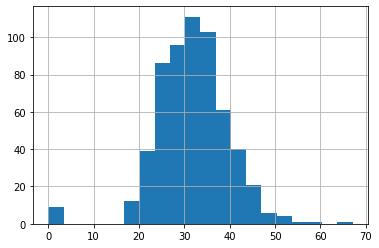

In [11]:
dfTrain.BMI.hist(bins=20)

<AxesSubplot:>

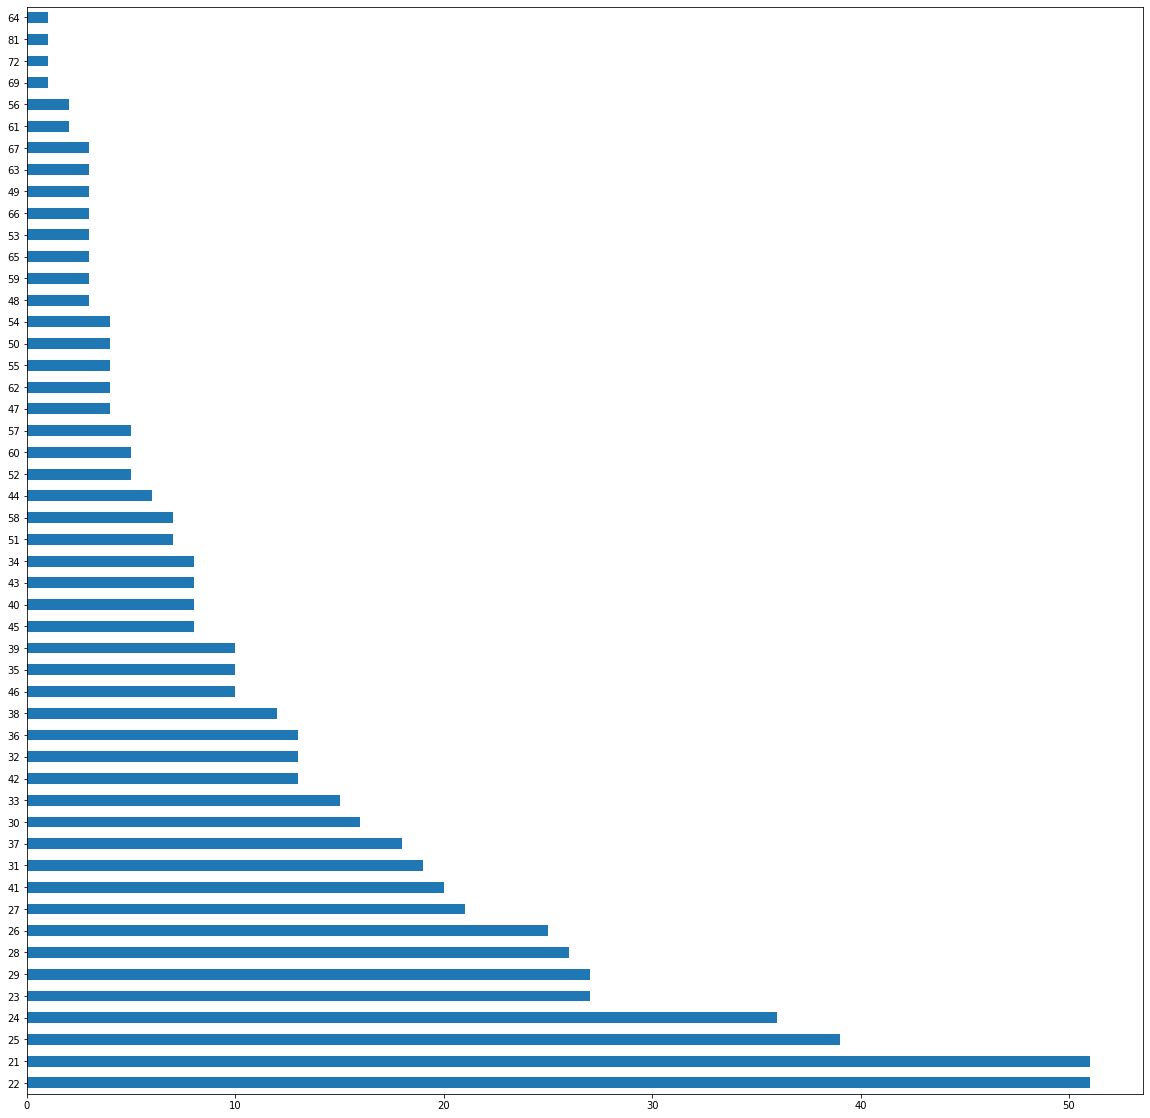

In [12]:
dfTrain.Age.value_counts().plot(kind='barh', figsize=(20,20))

Text(0.5, 0, '% high blood pressure')

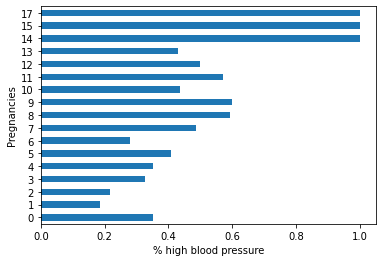

In [13]:
pd.concat([dfTrain, y_train], axis=1).groupby('Pregnancies').Outcome.mean().plot(kind='barh').set_xlabel('% high blood pressure')

Input functions are special functions that describe how data is fed into the model during the training process e.g. epochs, batch size etc.

The tensor flow model expects data to be a "tf.data.Dataset" object.

In [14]:
#Create feature columns
for col in dfTrain.columns:
    print(col)
    
featureColumns = []
for col in dfTrain.columns:
    featureColumns.append(tf.feature_column.numeric_column(col, dtype=tf.float32))
    
print(featureColumns)

Pregnancies
Glucose
BloodPressure
BMI
DiabetesPedigreeFunction
Age
[NumericColumn(key='Pregnancies', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='Glucose', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='BloodPressure', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='BMI', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='DiabetesPedigreeFunction', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='Age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]


In [15]:
def CreateInputFunction(dataDataFrame, labelDataFrame, numEpochs=25, shuffle=True, batchSize=32):
    def InputFunction():
        #tf.data.Dataset object creation
        dataSet = tf.data.Dataset.from_tensor_slices((dict(dataDataFrame), labelDataFrame))
        if shuffle:
            dataSet = dataSet.shuffle(1000)
        dataSet = dataSet.batch(batchSize).repeat(numEpochs)
        return dataSet
    return InputFunction

trainInputFunction = CreateInputFunction(dfTrain, y_train)
evaluationInputFunction = CreateInputFunction(dfEvaluate, y_evaluate, numEpochs=1, shuffle=False)


In [16]:
#Model creation
linearEstimator = tf.estimator.LinearClassifier(feature_columns=featureColumns)

#Model training
linearEstimator.train(trainInputFunction)
result = linearEstimator.evaluate(evaluationInputFunction)

clear_output()
print(result['accuracy'])

0.3559322


In [17]:
# Use model to make predictions
predictDictionaries = list(linearEstimator.predict(evaluationInputFunction))
index = randrange(177);
print(dfEvaluate.loc[index])
print(y_evaluate.loc[index])
print(predictDictionaries[index]['probabilities'])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Mauri\AppData\Local\Temp\tmpva9c3_io\model.ckpt-475
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Pregnancies                  10.000
Glucose                     115.000
BloodPressure                 0.000
BMI                           0.000
DiabetesPedigreeFunction      0.261
Age                          30.000
Name: 115, dtype: float64
1
[0.03170161 0.9682984 ]


### Classification

Takes input data and considers it between certain classes.

In [18]:
COLUMN_NAMES =  ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth', 'Species']
SPECIES = ['Setosa', 'Versicolor', 'Virginica']

In [19]:
trainPath = tf.keras.utils.get_file("iris_training.csv", "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv")
EvalPath = tf.keras.utils.get_file("iris_test.csv", "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv")

classifierTrain = pd.read_csv(trainPath, names=COLUMN_NAMES, header=0)
classifierEval = pd.read_csv(EvalPath, names=COLUMN_NAMES, header=0)

#trainClassification.pop('Id')
#evalClassification.pop('Id')

classificationTrainY = classifierTrain.pop('Species')
classificationEvalY = classifierEval.pop('Species')

#trainClassification.head()
classifierTrain.head()

,SepalLength,SepalWidth,PetalLength,PetalWidth
0,6.4,2.8,5.6,2.2
1,5.0,2.3,3.3,1.0
2,4.9,2.5,4.5,1.7
3,4.9,3.1,1.5,0.1
4,5.7,3.8,1.7,0.3


Classification also uses a special input function. The task of this function is analog to the one used in Linear Regression; to describe how data is fed into the model.

In [21]:
def ClassificationInputFunction(features, labels, training=True, batchSize=256):
    #tf.data.Dataset object creation
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))
    if training:
        dataset = dataset.shuffle(1000).repeat()
    return dataset.batch(batchSize)

Classification also uses feature columns.

In [20]:
classificationFC = []
for key in classifierTrain.keys():
    classificationFC.append(tf.feature_column.numeric_column(key=key))
    print(key)

SepalLength
SepalWidth
PetalLength
PetalWidth


For classification there is a noticably large amount of different algorithms/models that are used to implement it. Often used classifiers are 'LinearClassifier' and 'DNNClassifier', which stands for 'Deep-Neural-Network Classifier'.

As the name implies linear classifiers depend on linear correlations whereas DNN-classifier don't.

In [22]:
#Model creation
classifierModel = tf.estimator.DNNClassifier(feature_columns=classificationFC, hidden_units=[30,10], n_classes=3)

#Model training
classifierModel.train(input_fn=lambda: ClassificationInputFunction(classifierTrain,classificationTrainY, training=True),steps=5000)
#clear_output()

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Mauri\\AppData\\Local\\Temp\\tmp49obfng9', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorf

In [23]:
#Evaluates the precision of the model.
evaluationResult = classifierModel.evaluate(input_fn=lambda: ClassificationInputFunction(classifierEval,classificationEvalY, training=False))
print('Current accuracy was at {accuracy:0.2f}%'.format(**evaluationResult))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-10-21T14:06:55
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Mauri\AppData\Local\Temp\tmp49obfng9\model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.74570s
INFO:tensorflow:Finished evaluation at 2021-10-21-14:06:56
INFO:tensorflow:Saving dict for global step 5000: accuracy = 0.93333334, average_loss = 0.6001579, global_step = 5000, loss = 0.6001579
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5000: C:\Users\Mauri\AppData\Local\Temp\tmp49obfng9\model.ckpt-5000
Current accuracy was at 0.93%


In [24]:
# Creates input function without labels for making predictions
def EvaluationFunction(features, batchSize=256):
    return tf.data.Dataset.from_tensor_slices(dict(features)).batch(batchSize)

#Predict for example value
#I just made up reasonable values to test the prediction capabilities.
predict = {'SepalLength': [5.2], 'SepalWidth': [2.8], 'PetalLength': [2.5],'PetalWidth': [0.3]}
classifierPrediction = classifierModel.predict(input_fn=lambda: EvaluationFunction(predict))
for pred in classifierPrediction:
    print(pred)
    class_id = pred['class_ids'][0]
    probability = pred['probabilities'][class_id]
    #Copied this from the TensorFlow website
    print('Prediction is "{}" ({:.1f}%)'.format(SPECIES[class_id], 100 * probability))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Mauri\AppData\Local\Temp\tmp49obfng9\model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
{'logits': array([-0.34285748,  0.29142874, -0.04950126], dtype=float32), 'probabilities': array([0.23659699, 0.4461452 , 0.31725773], dtype=float32), 'class_ids': array([1], dtype=int64), 'classes': array([b'1'], dtype=object), 'all_class_ids': array([0, 1, 2]), 'all_classes': array([b'0', b'1', b'2'], dtype=object)}
Prediction is "Versicolor" (44.6%)


### Clustering

Clustering is an unsupervised ML algorithm, which creates clusters of similar data points.
One of those algorithms is "K-Means". 

The basic algorithm works as follows:
1. Randomly pick n points to place n centroids.
2. Assign all data points to one centroid based on euclidean distance.
3. Place centroid in the center of mass.
5. Repeat, starting from step 2 until any centroid must not be moved anymore.

### Hidden Markov Models

Hidden Markov Models consist of states, observations and transitions.

- States: Each Markov Model has a finite amount of states e.g. "hot", "cold", "rain", "sun" etc.
- Observations: Each state has specific observations based on a probability distribution.
- Transitions: Each state has a probability defining how likely it is to transition to a different states.



In [26]:
import tensorflow_probability as tfp

In [31]:
#TFP shortcut
tfd = tfp.distributions 
initialDistribution = tfd.Categorical(probs=[0.8, 0.2])
transitionDistribution = tfd.Categorical(probs=[[0.6, 0.4], [0.2, 0.8]])

#loc represents mean
#scale represents standard deviation
observationDistribution = tfd.Normal(loc=[0.0, 15.0], scale=[5.0, 10.0])

In [32]:
markovModel = tfd.HiddenMarkovModel(initial_distribution=initialDistribution, transition_distribution= transitionDistribution, 
                                    observation_distribution=observationDistribution, num_steps=5)

#This is a partially define tensor
mean = markovModel.mean()

with tf.compat.v1.Session() as session:
    print(mean.numpy())

[2.9999998 7.200001  8.88      9.552001  9.820802 ]
